## Introduction
---
- Machine Learning applications in the field of Medicine to support and help the diagnosis of various diseases is crucial, to catch these at an early state. For this the algorithms
used have to take into account the most telling characteristics about the tests performed to analyze the targeted anatomical part of the patient. This is true in the particular case of Brain Tumors where there are typical exams that are prescribged in order to find if there is a tumor in the cerebral cortex of the patient.
- With the intent to build a model that classifies the imagiological results of tests like CT scans and MRIs into 'healty' or 'cancer' classes, to support the specialists decisions, we decided to train said model with a dataset with about 4600 unique samples of these types of exams, consisting their image results. 
-Given time we will explore the classification between different types of cancer in the brain cancer category.
---
## Step 1 - Data Exploration and Preprocessing

- Inspecting the dataset structure and labels:  
  - here is where we can separate the dataset through the labels Cancer/Healthy;
  - given the separation we may start to operate in the dataset

- The 1st operation needed is to reduce the images to a fixed shape, normalizing them into the same resolution;
- Next we also need to split the dataset as said in the project proposal, in "Training Data" and "Testing Data";
---
#### Process
- For this step then we will use "pandas" library to read the CSV metadata in order to get the information provided about the images
- When this is completed we will separate the data into "Healthy" and "Cancer" lists
- After this the main preprocessing of the data will begin 

In [3]:
import numpy as np
import pandas as pd
\
DEBUG = True

csv_file = "./data/metadata_rgb_only.csv"

"""This method reads the data from a CSV file
returning said data."""
def read_data(csv_file):
    df = pd.read_csv(csv_file)
    return df 

data = read_data(csv_file)

if DEBUG == True:
    print(f"🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(data)
    

🔴--------------🔴   Debug   🔴--------------🔴

      Unnamed: 0                  image   class format mode          shape
0              0         Cancer (1).jpg   tumor   JPEG  RGB  (512, 512, 3)
1              2         Cancer (1).tif   tumor   TIFF  RGB  (256, 256, 3)
2              3        Cancer (10).jpg   tumor   JPEG  RGB  (512, 512, 3)
3              4        Cancer (10).tif   tumor   TIFF  RGB  (256, 256, 3)
4              5       Cancer (100).jpg   tumor   JPEG  RGB  (512, 512, 3)
...          ...                    ...     ...    ...  ...            ...
4456        4595  Not Cancer  (995).jpg  normal   JPEG  RGB  (168, 300, 3)
4457        4596  Not Cancer  (996).jpg  normal   JPEG  RGB  (509, 452, 3)
4458        4597  Not Cancer  (997).jpg  normal   JPEG  RGB  (197, 177, 3)
4459        4598  Not Cancer  (998).jpg  normal   JPEG  RGB  (217, 232, 3)
4460        4599  Not Cancer  (999).jpg  normal   JPEG  RGB  (221, 228, 3)

[4461 rows x 6 columns]


#### Step 1 - Completed

- For now we have a variable `data` that has all the information in the file metadata stored in an N column matrix. Since this is the case we can pick and choose the data that we need to separate in the different classes. 
---

## Step 2 - Splitting dataset by its label
---

In [4]:
def get_list(data, column):
    list = data[column] # get the info on column class
    return list 

# Get the image labels
labels = get_list(data, column="class")

if DEBUG == True:
    print(f"🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(labels, sep="\n")

# Get the images list
images = get_list(data, column="image")

if DEBUG == True:
    print(f"🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(images)

# Split the images into healty/cancer
cancer  = images[labels=="tumor"]
healthy = images[labels=="normal"]

print(cancer, healthy, sep="\n\n")

🔴--------------🔴   Debug   🔴--------------🔴

0        tumor
1        tumor
2        tumor
3        tumor
4        tumor
         ...  
4456    normal
4457    normal
4458    normal
4459    normal
4460    normal
Name: class, Length: 4461, dtype: object
🔴--------------🔴   Debug   🔴--------------🔴

0              Cancer (1).jpg
1              Cancer (1).tif
2             Cancer (10).jpg
3             Cancer (10).tif
4            Cancer (100).jpg
                ...          
4456    Not Cancer  (995).jpg
4457    Not Cancer  (996).jpg
4458    Not Cancer  (997).jpg
4459    Not Cancer  (998).jpg
4460    Not Cancer  (999).jpg
Name: image, Length: 4461, dtype: object
0         Cancer (1).jpg
1         Cancer (1).tif
2        Cancer (10).jpg
3        Cancer (10).tif
4       Cancer (100).jpg
              ...       
2416    Cancer (994).JPG
2417    Cancer (995).jpg
2418    Cancer (996).jpg
2419    Cancer (998).JPG
2420    Cancer (999).jpg
Name: image, Length: 2421, dtype: object

2421       Not C

### Step 2 - Completed
---


## Step 3 - Creation of Train and Testing datasets
---
- This allows to separate already both datasets.

In [5]:
import os
import shutil
import random as rand

DATA_DIR = "./data"    
TRAIN_DIR = "./data/train"
TEST_DIR  = "./data/test"
TEST_SPLIT = 0.2
SEED = 42

rand.seed(SEED)

classes = ["cancer", "healthy"]

for cls in classes:
    os.makedirs(os.path.join(TRAIN_DIR, cls), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, cls), exist_ok=True)

    files = [f for f in os.listdir(os.path.join(DATA_DIR, cls)) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    rand.shuffle(files)

    split_idx = int(len(files) * TEST_SPLIT)
    for f in files[:split_idx]:
        shutil.copy2(os.path.join(DATA_DIR, cls, f), os.path.join(TEST_DIR, cls, f))
    for f in files[split_idx:]:
        shutil.copy2(os.path.join(DATA_DIR, cls, f), os.path.join(TRAIN_DIR, cls, f))

print("✅ Dataset split done!")


✅ Dataset split done!


### Step 3 - Completed
---

## Step 4 - Plotting images
---
- Separation of the images into the binary classes predetermined: `cancer` & `healthy` 
- With this we have the possibility of determining the priors for example
- We should also split the dataset in `training` and `testing data` @ this point

🔴--------------🔴   Debug   🔴--------------🔴


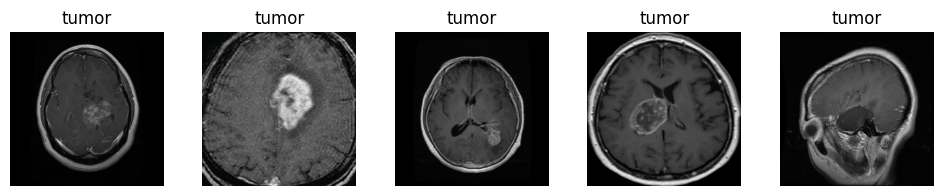

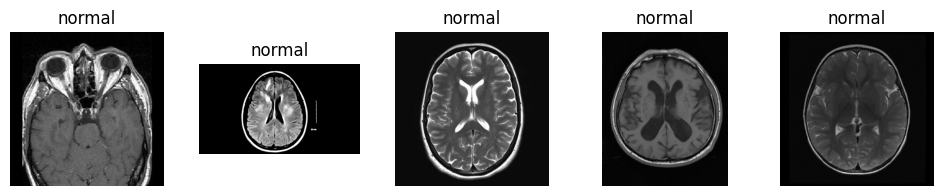

Number of cancer images: 2421
Number of healthy images: 2040


In [6]:
import matplotlib.pyplot as plt
from PIL import Image


cancer_img_dir= "./data/cancer"
healthy_img_dir = "./data/healthy"

N = 5

def random_plot(image_list, label, image_dir, n=N):
    plt.figure(figsize=(12,2))
    for i, img_name in enumerate(image_list[:n]):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.show()

if DEBUG == True:
    print("🔴--------------🔴   Debug   🔴--------------🔴")
    random_plot(cancer.to_list(), "tumor", cancer_img_dir)
    random_plot(healthy.to_list(), "normal", healthy_img_dir)
    print(f"Number of cancer images: {len(cancer)}")
    print(f"Number of healthy images: {len(healthy)}")

### Step 4 - Completed
---

## Step 5 - Image Preprocessing/Normalization/Reshape and Splitting
---
- Since the images have different resolutions and formats they should be normalized to the same size in order to build a solid foundation of comparison to train the model.
- To deal with that processing we decided to resize all images to a 256x256 resolution, although that number can be changed.
    - All 'L' format images shall be converted to 'RGB'.

- These will be split in an 80/20 where both classes have to be reasonably represented in the samples, especially in the training data
- Explain datagen.flow and respective variables

Found 2890 images belonging to 2 classes.
Found 722 images belonging to 2 classes.
🔴--------------🔴   Debug   🔴--------------🔴
Shape of first image: (128, 128, 3)


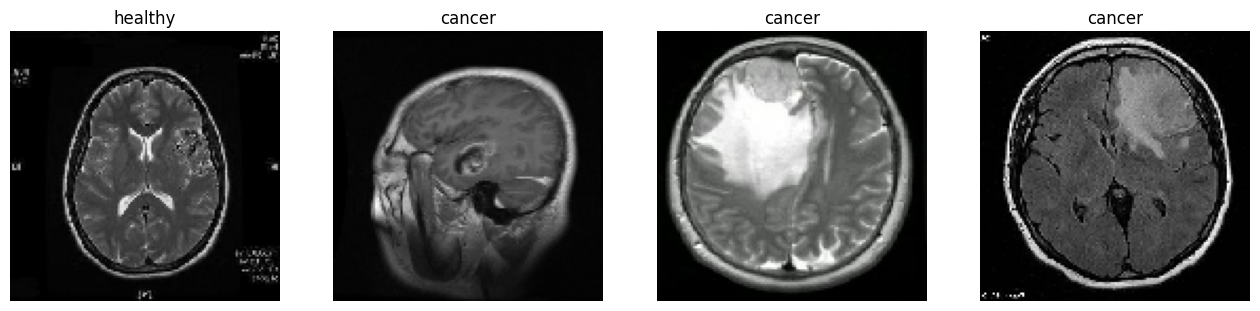

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2   # 20% Testing 80% Training
)

batch_size = 4
img_size = (128,128)

train_gen = datagen.flow_from_directory( # flow_from_directory() by default converts to RGB
    TRAIN_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

if DEBUG == True:
    print("🔴--------------🔴   Debug   🔴--------------🔴")
    images, labels = next(train_gen)  # batch_size images

    # Print shape of the first image to confirm size
    print("Shape of first image:", images[0].shape)  # should be (128,128,3) if you set target_size=(128,128)

    # Plot first N images in the batch
    N = min(8, len(images))  # just in case batch_size < 8
    plt.figure(figsize=(16, 4))
    for i in range(N):
        plt.subplot(1, N, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title('cancer' if labels[i]==0 else 'healthy')
    plt.show()


### Step 5 - Completed
---

## Step 6 - Validating CNN model 
---
- As the chosen model totally reflects the results of our program, we decided to stick to CNN (Convolutional Neural Network) that is pretty reliable when it comes to analyzing image, video and music data.
- Source of inspiration : https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial

In [8]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# model = Sequential([
#     Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
#     MaxPooling2D(2,2),
#     Conv2D(32, (3,3), activation='relu'),
#     MaxPooling2D(2,2),
#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(2,2),
#     Flatten(),
#     Dense(32, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['accuracy', 'precision', 'recall']
# )

# history = model.fit(
#     train_gen,        
#     validation_data=val_gen,  # To confront to validate results
#     epochs=30,
#     verbose=1
# )

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False

# classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    verbose=1
)

# this part implements an optional fine-tuning of the base model - did not test this yet
# base_model.trainable = True
# for layer in base_model.layers[:-25]:  # freeze earlier layers
#     layer.trainable = False

# model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # lower LR for fine-tuning
#               loss='binary_crossentropy',
#               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# history_fine = model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=6,
#     steps_per_epoch=len(train_gen),
#     validation_steps=len(val_gen),
#     verbose=1
# )

2025-11-29 14:51:09.577795: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12
723/723 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.8478 - loss: 0.3397 - precision: 0.8333 - recall: 0.8383 - val_accuracy: 0.8920 - val_loss: 0.2563 - val_precision: 0.8153 - val_recall: 0.9910
Epoch 2/12
723/723 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9183 - loss: 0.2045 - precision: 0.9111 - recall: 0.9124 - val_accuracy: 0.8975 - val_loss: 0.2446 - val_precision: 0.8202 - val_recall: 0.9970
Epoch 3/12
723/723 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9439 - loss: 0.1494 - precision: 0.9335 - recall: 0.9461 - val_accuracy: 0.9681 - val_loss: 0.1053 - val_precision: 0.9698 - val_recall: 0.9611
Epoch 4/12
723/723 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9543 - loss: 0.1129 - precision: 0.9453 - recall: 0.9566 - val_accuracy: 0.9280 - val_loss: 0.1881 - val_precision: 0.8730 - val_recall: 0.9880
Epoch 5/12
723/723 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9564 - loss: 0.1021 - precision: 0.

#### Step 6 - Completed

-  Using `MobileNetV2` pre-trained model set to not trainable we add a classifier head with the `GlobalAveragePooling2D`which produces and output which corresponds to a single signamoid neuron for binary classification.
-  then we compile the model with the `adam` optimization, loss as `binary_crossentropy` and the assessment metrics are : `accuracy`, `precision`, `recall` 
- after we use `train_gen` and `val_gen` to train the model splitting the steps by using epochs and limiting the number of epoch steps to the values `steps_per_epoch` and `validation_steps`
- Essentialy corresponds to training a base model
---

## Step 7 - Evaluating the trained Base Model on the test data

- here we are taking a look at the metrics of the model trained when it omes to the test data
- we also want to build the confusion matrix to figure out what the false negatives and the false positives look like in the current model

In [9]:
import math
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, 
                             precision_recall_curve, average_precision_score, precision_score,
                             recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef)

test_gen= datagen.flow_from_directory(
  TEST_DIR,
  target_size=img_size,
  batch_size=batch_size,
  class_mode='binary',
  shuffle=False
)

steps=math.ceil(test_gen.samples / batch_size)

# Prediction (probabilities)
y_prob=model.predict(test_gen, steps=steps, verbose=1).ravel()
y_true=test_gen.classes
y_pred=(y_prob>=0.5).astype(int)

# Metrics - Important for the model assessment -accuracy was said (in class) to not be the best for cancer applications - altough i think these 10 should be enough ;)
cm=confusion_matrix(y_true, y_pred)
tn, fp, fn, tp= cm.ravel()
sensitivity= tp / (tp + fn) if(tp + fn) > 0  else 0.0
specificity= tn / (tn + fp) if(tn+fp) > 0 else 0.0
precision=precision_score(y_true, y_pred, zero_division=0)
recall=recall_score(y_true, y_pred, zero_division=0)
f1=f1_score(y_true, y_pred, zero_division=0)
roc_auc=roc_auc_score(y_true, y_prob)
ap=average_precision_score(y_true, y_prob)
mcc=matthews_corrcoef(y_true, y_pred)
ba=balanced_accuracy_score(y_true, y_pred)

print("Class mapping (from generator):", test_gen.class_indices)
print("\nConfusion Matrix: \n", cm)
print(f"\nSensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision (AUPRC): {ap:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Balanced Accuracy: {ba:.4f}")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[k for k,v in sorted(test_gen.class_indices.items(), key=lambda x:x[1])]))

Found 902 images belonging to 2 classes.
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Class mapping (from generator): {'cancer': 0, 'healthy': 1}

Confusion Matrix: 
 [[474  11]
 [ 15 402]]

Sensitivity (Recall): 0.9640
Specificity: 0.9773
precision: 0.9734
recall: 0.9640
F1 score: 0.9687
ROC AUC: 0.9959
Average Precision (AUPRC): 0.9952
MCC: 0.9420
Balanced Accuracy: 0.9707
Classification Report:
              precision    recall  f1-score   support

      cancer       0.97      0.98      0.97       485
     healthy       0.97      0.96      0.97       417

    accuracy                           0.97       902
   macro avg       0.97      0.97      0.97       902
weighted avg       0.97      0.97      0.97       902



#### Step 7 - Completed

- Looking at the data there is in the confuction matrix interesting info. There were 475 classification of images into the class cancer which were in fact cancer and 407 classifications as healthy which were in fact healthy. 
- however there were some false positves and false negatives - we should now work on a way to reduce the number of the false negatives
---

## Step 8 - Extracting features to use in SVM model



In [ ]:
from sklearn.preprocessing import StandardScaler

feature_output = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=feature_output)

def extract_features(generator, extractor_model):
    steps = math.ceil(generator.samples / generator.batch_size)
    feats = extractor_model.predict(generator, steps=steps, verbose=1)
    labels = generator.classes  
    return feats, labels

X_train_feats, y_train = extract_features(train_gen, feature_extractor)
X_val_feats,   y_val   = extract_features(val_gen, feature_extractor)
X_test_feats,  y_test  = extract_features(test_gen, feature_extractor)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feats)
X_val_scaled   = scaler.transform(X_val_feats)
X_test_scaled  = scaler.transform(X_test_feats)

# np.save('X_train_feats.npy', X_train_feats); np.save('y_train.npy', y_train)
model.summary()


723/723 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


## Step 9 - Training and Evaluating SVM


In [16]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1.0, probability=True, class_weight=None)  # try class_weight='balanced' if classes are imbalanced
svm.fit(X_train_scaled, y_train)

y_prob = svm.predict_proba(X_test_scaled)[:,1]   # probability for positive class
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel() if cm.size==4 else (0,0,0,0)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
mcc = matthews_corrcoef(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)

print("Class mapping (from generator):", test_gen.class_indices)
print("\nConfusion Matrix: \n", cm)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision (AUPRC): {ap:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Balanced Accuracy: {ba:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[k for k,v in sorted(test_gen.class_indices.items(), key=lambda x:x[1])]))

Class mapping (from generator): {'cancer': 0, 'healthy': 1}

Confusion Matrix: 
 [[485   0]
 [417   0]]
Sensitivity (Recall): 0.0000
Specificity: 1.0000
precision: 0.0000
recall: 0.0000
F1 score: 0.0000
ROC AUC: 0.4419
Average Precision (AUPRC): 0.4312
MCC: 0.0000
Balanced Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

      cancer       0.54      1.00      0.70       485
     healthy       0.00      0.00      0.00       417

    accuracy                           0.54       902
   macro avg       0.27      0.50      0.35       902
weighted avg       0.29      0.54      0.38       902



/home/joao/Documents/feup/masters/1st/1sem/apc/ml-mainproject/project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/joao/Documents/feup/masters/1st/1sem/apc/ml-mainproject/project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/joao/Documents/feup/masters/1st/1sem/apc/ml-mainproject/project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi